# 1. Setup

## 1.1 Install Dependencies

In [3]:
!pip install opencv-python

     ---------------------------------------- 35.6/35.6 MB 1.2 MB/s eta 0:00:00


## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2 
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Create Folder Structures

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [12]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [13]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [4]:
# Import uuid library to generate unique image names
import uuid

In [8]:
# Establish a connection to the web cam
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[60:60+250, 180:180+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positive
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

## 2.3 Data Augmentation

In [9]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(100), np.random.randint(100)))
        data.append(img)
    return data

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(280)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(280)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(280)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data\\anchor\\98291d83-f09a-11ec-bd2a-3cf8625c130e.jpg'


## 3.2 Preprocessing - Scale and Resize

In [13]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 105x105x3
    img = tf.image.resize(img, (105,105))
    # Scale image to be between 0 and 1
    img = img /255.0

    # Return image
    return img

## 3.3 Create Labelled Dataset

In [27]:
# (anchor, positive) => 1
# (anchor, negative) => 0

In [14]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'data\\anchor\\a0b23f2d-f09a-11ec-9e26-3cf8625c130e.jpg',
 b'data\\positive\\22ac30d9-f09a-11ec-9100-3cf8625c130e.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [17]:
res = preprocess_twin(*example)

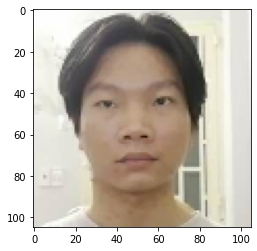

In [18]:
plt.imshow(res[1])

In [19]:
res[2]

1.0

In [20]:
# Build data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [21]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [23]:
from tensorflow.keras.layers import MaxPool2D

In [24]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPool2D((2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPool2D((2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPool2D((2,2), padding='same')(c3)

    # Final block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [25]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## 4.2 Build Distance Layer

In [3]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Make Siamese Model

In [27]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_image', shape=(105, 105, 3))

    # Validation image in the network
    validation_image = Input(name='validation_image', shape=(105, 105, 3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [28]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[

# 5. Training

## 5.1 Setup Loss and Optimizer

In [29]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [30]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [31]:
checkpoint_dir = './FV_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [32]:
test_batch = train_data.as_numpy_iterator()

In [33]:
batch1 = test_batch.next()

In [34]:
X = batch1[:2]

In [35]:
y = batch1[2]

In [36]:
y

array([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [37]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## 5.4 Building Training Loop

In [38]:
# Import metric calculation
from tensorflow.keras.metrics import Precision, Recall

In [39]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Create a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [40]:
EPOCHS = 50

In [41]:
train(train_data, EPOCHS=EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
25/25 [==============================] - 181s 6s/step
0.27401185 0.6510417 0.9259259

 Epoch 2/50
25/25 [==============================] - 161s 6s/step
0.11944149 0.9800995 0.97044337

 Epoch 3/50
25/25 [==============================] - 126s 5s/step
0.041885257 1.0 0.9946808

 Epoch 4/50
25/25 [==============================] - 104s 4s/step
0.0007505776 1.0 1.0

 Epoch 5/50
25/25 [==============================] - 112s 4s/step
0.06123526 1.0 1.0

 Epoch 6/50
25/25 [==============================] - 142s 6s/step
0.06263041 1.0 1.0

 Epoch 7/50
25/25 [==============================] - 185s 7s/step
0.027415782 1.0 1.0

 Epoch 8/50
25/25 [==============================] - 249s 10s/step
0.0017931735 1.0 1.0

 Epoch 9/50
25/25 [==============================] - 123s 5s/step
0.0020745688 1.0 1.0

 Epoch 10/50
25/25 [===========

KeyboardInterrupt: 

## 6. Evaluate Model

## 6.1 Import Metrics

In [4]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [43]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [44]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [45]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]

In [46]:
y_true

array([1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [47]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [48]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [49]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 
print(yhat)
print(y_true)
print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 759ms/step
[[9.9996543e-01]
 [1.0000000e+00]
 [9.9999696e-01]
 [9.9998021e-01]
 [1.5487604e-10]
 [1.0922458e-11]
 [1.0000000e+00]
 [9.9999976e-01]]
[1. 1. 1. 1. 0. 0. 1. 1.]
1.0 1.0


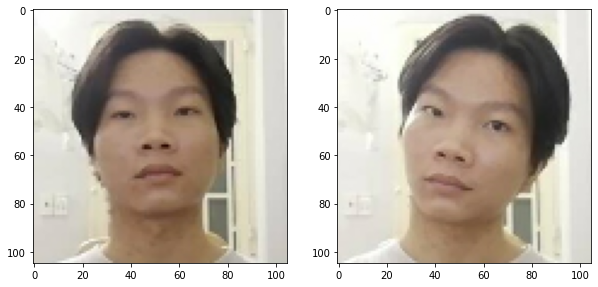

In [50]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[6])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[6])

# Renders cleanly
plt.show()

# 7. Save Model

In [5]:
# Save weights
siamese_model.save('siamesemodel.h5')

NameError: name 'siamese_model' is not defined

In [6]:
# Reload model
siamese_model = tf.keras.models.load_model('app\siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [53]:
# Make predictions with reload model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[9.9996543e-01],
       [1.0000000e+00],
       [9.9999696e-01],
       [9.9998021e-01],
       [1.5487604e-10],
       [1.0922458e-11],
       [1.0000000e+00],
       [9.9999976e-01]], dtype=float32)

In [54]:
# View model summary
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[

# 8. Real Time Test

## 8.1 Verification Function

In [56]:
os.listdir(os.path.join('application_data', 'verification_images'))

['9e5feab6-ed7f-11ec-b19f-9b32ae05865a.jpg',
 'a11aa524-ed7f-11ec-88d1-9b32ae05865a.jpg',
 'a2e726a6-ed7f-11ec-88ae-9b32ae05865a.jpg',
 'a857ca6b-ed7f-11ec-aead-9b32ae05865a.jpg',
 'a9b7c8fd-ed7f-11ec-88a8-9b32ae05865a.jpg',
 'aabba46a-ed7f-11ec-b685-9b32ae05865a.jpg',
 'adaa8501-ed7f-11ec-9d5c-9b32ae05865a.jpg',
 'af9a8c33-ed7f-11ec-85ea-9b32ae05865a.jpg',
 'ded9f6a6-ed7f-11ec-a261-9b32ae05865a.jpg',
 'df33f49d-ed7f-11ec-a75f-9b32ae05865a.jpg',
 'df8485c8-ed7f-11ec-a7a1-9b32ae05865a.jpg',
 'e052ab1e-ed7f-11ec-80e6-9b32ae05865a.jpg',
 'e07108ce-ed7f-11ec-9229-9b32ae05865a.jpg',
 'e0bcb79d-ed7f-11ec-850b-9b32ae05865a.jpg',
 'e1264ec6-ed7f-11ec-a87f-9b32ae05865a.jpg',
 'e2221406-ed7f-11ec-bbb1-9b32ae05865a.jpg',
 'e272cc07-ed7f-11ec-b390-9b32ae05865a.jpg',
 'e2c865e8-ed7f-11ec-a1a2-9b32ae05865a.jpg',
 'e2f56971-ed7f-11ec-a670-9b32ae05865a.jpg',
 'e31e0008-ed7f-11ec-87a4-9b32ae05865a.jpg',
 'e40f8c04-ed7f-11ec-b4b7-9b32ae05865a.jpg',
 'e4b5de17-ed7f-11ec-9592-9b32ae05865a.jpg',
 'e55615b3

In [57]:
def verify(model, detection_threshold, verification_threshold):
    # Build result array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    # Return predicted results, verification
    return results, verified 

## 8.2 OpenCV Real Time Verification

In [59]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[60:60+250, 180:180+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        #  Save input image tp application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        result, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 160ms/step
True
1/1 [==============================] - 0s 102ms/step
True
1/1 [==============================] - 0s 113ms/step
True
1/1 [==============================] - 0s 121ms/step
False


In [55]:
np.sum(np.squeeze(result) > 0.9)

25

In [56]:
result

[array([[0.99962825]], dtype=float32),
 array([[0.856797]], dtype=float32),
 array([[0.9999967]], dtype=float32),
 array([[0.75716245]], dtype=float32),
 array([[0.9998595]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99978834]], dtype=float32),
 array([[0.99982125]], dtype=float32),
 array([[0.88938296]], dtype=float32),
 array([[0.94681054]], dtype=float32),
 array([[0.9753217]], dtype=float32),
 array([[0.96780366]], dtype=float32),
 array([[0.9866544]], dtype=float32),
 array([[0.99115473]], dtype=float32),
 array([[0.95269847]], dtype=float32),
 array([[0.9834866]], dtype=float32),
 array([[0.9834866]], dtype=float32),
 array([[0.9834866]], dtype=float32),
 array([[0.9863814]], dtype=float32),
 array([[0.9809737]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9864876]], dtype=float32),
 array([[0.9992537]], dtype=float32),
 array([[0.9999499]], dtype=float32),
 